# Аналитика в Яндекс.Афише

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
статистика рекламных расходов.

Вы изучите:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Описание данных:

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv', sep=',')
orders = pd.read_csv('/datasets/orders_log.csv', sep=',')
costs = pd.read_csv('/datasets/costs.csv', sep=',')

Получим общую информацию о данных:

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
visits.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [7]:
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [8]:
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


Приведём название столбцов к нижнему регистру

In [9]:
# <Приведение к нижнему регистру>
visits.columns = map(str.lower, visits.columns)
orders.columns = map(str.lower, orders.columns)

### Замена типа данных

Замени тип данных в столбцах с датой с object на datetime

In [10]:
# <Замена типа данных на datetime>
visits['end ts'] = pd.to_datetime(visits['end ts'], format='%Y-%m-%d')
visits['start ts'] = pd.to_datetime(visits['start ts'], format='%Y-%m-%d')
orders['buy ts'] = pd.to_datetime(orders['buy ts'], format='%Y-%m-%d')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

### Шаг 2. Постройте отчёты и посчитайте метрики

### 2.1 Продукт

#### Сколько людей пользуются в день, неделю, месяц?

Изучим данные пользовательской активности, найдя сколько людей пользуются продуктом в день, неделю, месяц.

In [11]:
# <Добавление в таблицу visits столбцов с месяцем, неделей и датой>
visits['session_month']  = visits['start ts'].dt.month
visits['session_week']  = visits['start ts'].dt.week
visits['session_date'] = visits['start ts'].dt.date

Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдём среднее:

In [12]:
# <Посчитаем среднее кол-во, использующих продукт людей>
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'}).mean()
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()

In [13]:
print(int(mau_total))
print(int(wau_total))
print(int(dau_total))

23228
5825
907


В среднем в день продуктом пользуются 907 раз

In [14]:
# <Посчитаем регулярность использования>
sticky_wau = dau_total / wau_total *100
sticky_mau = dau_total / mau_total *100

In [15]:
print(float(sticky_wau.round(2)))
print(float(sticky_mau.round(2)))

15.59
3.91


Построим график с количеством уникальных визитов по устройствам

Text(0.5, 1.0, 'График количества визитов по устройствам')

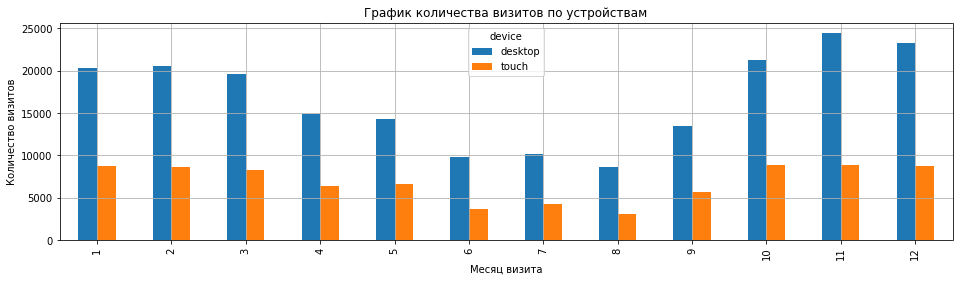

In [16]:
# <График количества визитов по устройствам>
device_plot = visits.pivot_table(index='session_month', columns='device', values='uid', aggfunc='nunique').plot(grid=True, kind='bar', figsize=(16, 4))
plt.xlabel('Месяц визита')
plt.ylabel('Количество визитов')
plt.title('График количества визитов по устройствам')

#### Вывод

В среднем в день продуктом пользуются 907 раз. С компьютера заходят примерно в 2,5 раза чаще, чем с мобильных устройств. Пиковые месяцы - октябрь, ноябрь и декабрь. Самые не активные летние. Можно предположить, что это объясняется периодом отпусков.

#### Сколько сессий в день?

Найдем сколько сессий в среднем в день.

In [17]:
# <Группировка данных и расчет кол-во сессий в день>
sessions_user = visits.groupby('session_date').agg({'uid': ['count']})
sessions_user.columns = ['sum_sessions']
sessions_user['sum_sessions'].mean()

987.3626373626373

Далее определим сколько сессий приходится на одного пользователя в месяц.

In [18]:
# <Группировка данных и расчет кол-во сессий на одного пользователя в месяц>
sessions_user = visits.groupby('session_month').agg({'uid': ['count','nunique']})
sessions_user.columns = ['n_sessions', 'n_users']
sessions_user['sess_per_user'] = (sessions_user['n_sessions'] / sessions_user['n_users'])
sessions_user

,n_sessions,n_users,sess_per_user
session_month,,,
1,36939,28716,1.286356
2,37182,28749,1.293332
3,35679,27473,1.298693
4,26515,21008,1.262138
5,26635,20701,1.286653
6,16505,13259,1.244815
7,17828,14183,1.256998
8,14355,11631,1.234202
9,23907,18975,1.259921


Text(0.5, 1.0, 'График количества сессий на одного пользователя в месяц')

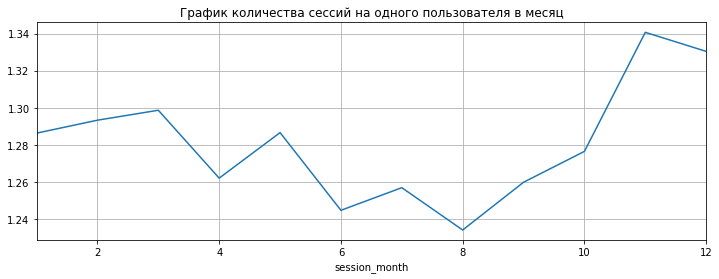

In [19]:
sessions_user['sess_per_user'].plot(grid=True, figsize=(12, 4))
plt.title('График количества сессий на одного пользователя в месяц')

#### Вывод

В месяц один пользователь в среднем проводит в приложении максимум 1.3 сессии. Не сказать, что продукт используется регулярно

#### Сколько длится одна сессия? 

Найдем сколько в среднем длится одна сессия

In [20]:
# <Добавим столбец и посчитаем среднее>
visits['session_duration_sec'] = (visits['end ts'] - visits['start ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

Посмотрим на распределение

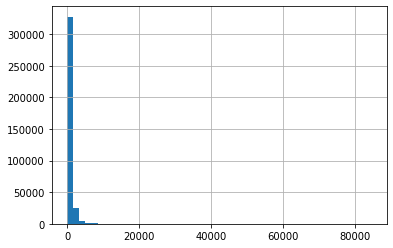

In [21]:
# <Построим гистограмму>
visits['session_duration_sec'].hist(bins=50)

Длина сессий распределена неравномерно, поэтому далее рассчитаем моду:

In [22]:
int(visits['session_duration_sec'].mode())

60

#### Вывод

Мода равняется 60 секундам. Если пользователь успевает за это время сделать заказ, то всё отлично, а если нет — нужно проверить, что ему мешает.

#### Как часто люди возвращаются?

In [23]:
# <Пересохраню данные в отдельный датафрейм>
user_activity = visits[['uid','start ts','source id','device']]

# <Нахожу первый заход на сайт>
first_session_date = user_activity.groupby(['uid'])['start ts'].min()
first_session_date.name = 'first_session_date'

# <Добавляем столбец>
user_activity = user_activity.join(first_session_date,on='uid')

# <Форматируем в нужный формат>
user_activity['session_month'] = user_activity['start ts'].astype('datetime64[M]')
user_activity['first_session_month'] = user_activity['first_session_date'].astype('datetime64[M]')

user_activity.head()

,uid,start ts,source id,device,first_session_date,session_month,first_session_month
0,16879256277535980062,2017-12-20 17:20:00,4,touch,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,104060357244891740,2018-02-19 16:53:00,2,desktop,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,7459035603376831527,2017-07-01 01:54:00,5,touch,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,16174680259334210214,2018-05-20 10:59:00,9,desktop,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,9969694820036681168,2017-12-27 14:06:00,3,desktop,2017-12-27 14:06:00,2017-12-01,2017-12-01


Найдем время жизни когорты, вычтем из даты захода дату первого посещения. Переведем в месяцы.

In [24]:
# <Время жизни когорты>
user_activity['cohort_lifetime'] = user_activity['session_month'] - user_activity['first_session_month'] 

# <Перевожу в месяц>
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int')

Найдем количество уникальных пользователей в каждом месяце.

In [25]:
# <Группировка данных>
cohorts = user_activity.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Найдем количество пользователей изначально в каждой когорте

In [26]:
# <Расчет исходного количества пользователей в когорте>
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
inital_users_count = inital_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(inital_users_count,on='first_session_month')

Найдем retention каждой когорты

In [27]:
# <Расчет Retention Rate>
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

In [28]:
# <Создание сводной таблицы>
retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[Text(0, 0.5, '2017-06-01'),
 Text(0, 1.5, '2017-07-01'),
 Text(0, 2.5, '2017-08-01'),
 Text(0, 3.5, '2017-09-01'),
 Text(0, 4.5, '2017-10-01'),
 Text(0, 5.5, '2017-11-01'),
 Text(0, 6.5, '2017-12-01'),
 Text(0, 7.5, '2018-01-01'),
 Text(0, 8.5, '2018-02-01'),
 Text(0, 9.5, '2018-03-01'),
 Text(0, 10.5, '2018-04-01'),
 Text(0, 11.5, '2018-05-01')]

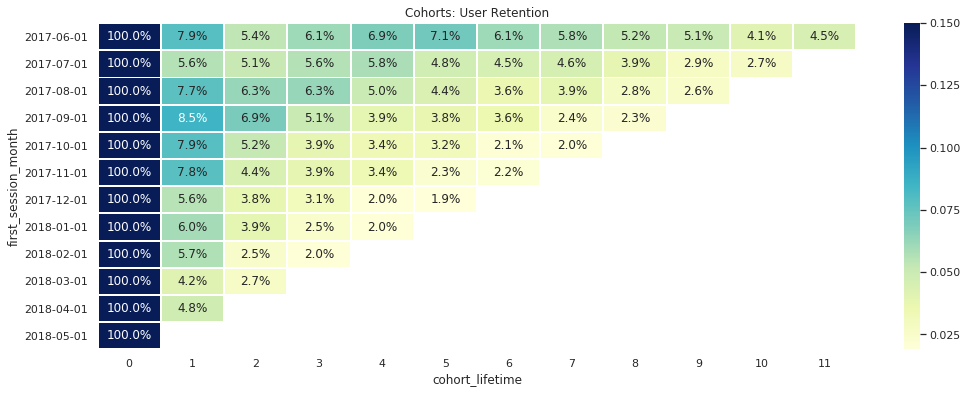

In [29]:
# <Создание тепловой карты>
sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, cmap="YlGnBu", vmax=0.15);
ax.set_yticklabels(retention_pivot.index.date)

#### Вывод

Retention Rate в первый месяц убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне 2017 Retention Rate в первый месяц составляет 7,9%, то для пользователей, пришедших в апреле 2018 — уже 4,8%. Так, за 11 месяцев коэффициент удержания упал на 3,1%. Это говорит, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки.

### 2.2 Продажи

#### Когда люди начинают покупать?

Добавим в таблицу orders столбец со временем первой сесии. 

In [30]:
# <Добавим в таблицу orders столбец first_session_date>
orders = orders.join(first_session_date,on='uid')

Добавим столбец с разницей между временем покупки и началом первой сессии.

In [31]:
# <Добавим столбец>
orders['orders_time'] = orders['buy ts'] - orders['first_session_date'] 
orders['orders_time'] = orders['orders_time'] / np.timedelta64(1,'h')

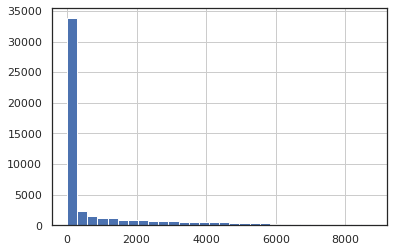

In [32]:
# <Построим гистограмму>
orders['orders_time'].hist(bins=30)

Посчитаем медиану по этому столбцу, т.к. есть выбросы по показателю.

In [33]:
# <Найдем медиану с момента начала сессии до заказа>
orders['orders_time'].median().round(1)

3.4

#### Вывод

Люди покупают примерно через 3,4 ч с момента первого захода на сайт. 

#### Сколько раз покупают за период? 

Определим сколько раз пользователи покупают за период, построив график.

Text(0.5, 1.0, 'Количество покупок за период')

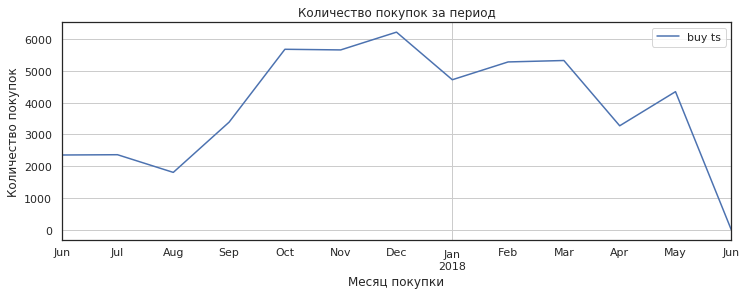

In [34]:
# <Добавим столбец с номером месяца>
orders['buy_month'] = orders['buy ts'].astype('datetime64[M]')

# <Построим график>
orders.pivot_table(index='buy_month',values='buy ts',aggfunc='count').plot(grid=True, figsize=(12, 4))
plt.xlabel('Месяц покупки')
plt.ylabel('Количество покупок')
plt.title('Количество покупок за период')

#### Вывод

На графике видно, что больше всего покупок было совершенно в декабре 2017 (более 100 тыс. раз и в феврале 2018 (около 90 тыс. раз). Меньше всего покупок в летние месяцы (30-40 тыс. раз)

#### Какой средний чек?

Сперва сгруппируем данные по когорте first_order_month и месяцу совершения заказа order_month

In [35]:
# <Группировка данных по когорте first_order_month и месяцу совершения заказа order_month>
first_order_date = orders.groupby('uid')['buy ts'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy ts'].astype('datetime64[M]')
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'count'})
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2354
                  2017-07-01    981.82   177
                  2017-08-01    885.34   174
                  2017-09-01   1931.30   226
                  2017-10-01   2068.58   292

Найдём средний чек покупателя.

In [36]:
# <Расчет среднего чека>
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts['revenue_per_user'].mean().round(2)

7.65

In [37]:
orders_grouped_by_cohorts

revenue   uid  revenue_per_user
first_order_month order_month                                  
2017-06-01        2017-06-01    9557.49  2354          4.060106
                  2017-07-01     981.82   177          5.547006
                  2017-08-01     885.34   174          5.088161
                  2017-09-01    1931.30   226          8.545575
                  2017-10-01    2068.58   292          7.084178
...                                 ...   ...               ...
2018-03-01        2018-05-01    1114.87   176          6.334489
2018-04-01        2018-04-01   10600.69  2495          4.248774
                  2018-05-01    1209.92   195          6.204718
2018-05-01        2018-05-01   13925.76  3249          4.286168
2018-06-01        2018-06-01       3.42     1          3.420000

[79 rows x 3 columns]

Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, как изменяется средний чек с течением времени

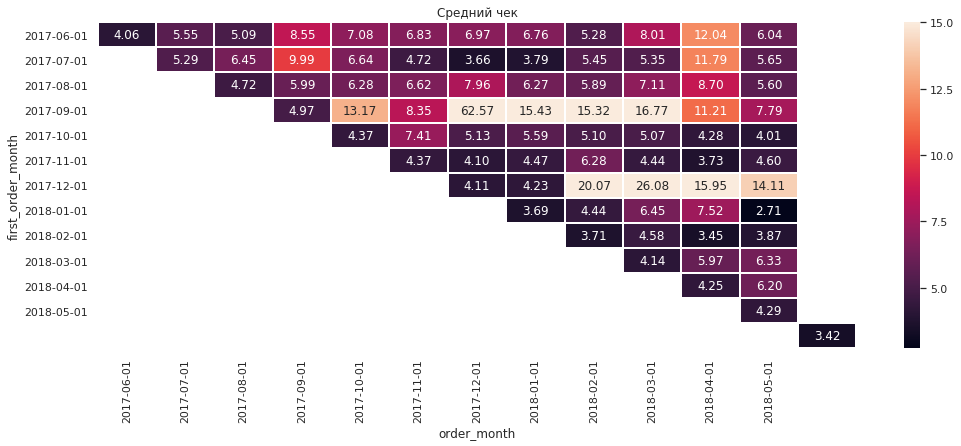

In [38]:
# <Постройка сводной таблицы>
orders_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')

# <Создание тепловой карты>
sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('Средний чек')
ax = sns.heatmap(orders_pivot, annot=True, fmt='.2f', linewidths=1, vmax=15);
ax.set_yticklabels(retention_pivot.index.date)
ax.set_xticklabels(retention_pivot.index.date)
plt.show()

#### Вывод

По таблице видно, что наибольший средний чек у пользователей сентябрьской, декабрьской когорты и июньской когорты. Средний чек по всем пользователям равен 7,65.

#### Сколько денег приносят? (LTV)

Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [39]:
# <Считаем кол-во новых покупателей>
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'buyers']
cohort_sizes

,first_order_month,buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [40]:
# <Группируем таблицу>
cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [41]:
# <Объединение таблиц>
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Добавим в таблицу report валовую прибыль (умножив выручку на маржинальность) и возраст когорты.
Примем, что средняя маржинальность магазина составляет 1000%

In [42]:
# <Расчет валовой прибыли и возраста когорты>
margin_rate = 1

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,buyers,order_month,revenue,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4


Найдём LTV, разделив валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Для наглядности визуализируем когорты в виде сводной таблицы:

In [43]:
# <Нахождение LTV>
report['ltv'] = report['gp'] / report['buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

[Text(0, 0.5, '2017-06-01'),
 Text(0, 1.5, '2017-07-01'),
 Text(0, 2.5, '2017-08-01'),
 Text(0, 3.5, '2017-09-01'),
 Text(0, 4.5, '2017-10-01'),
 Text(0, 5.5, '2017-11-01'),
 Text(0, 6.5, '2017-12-01'),
 Text(0, 7.5, '2018-01-01'),
 Text(0, 8.5, '2018-02-01'),
 Text(0, 9.5, '2018-03-01'),
 Text(0, 10.5, '2018-04-01'),
 Text(0, 11.5, '2018-05-01')]

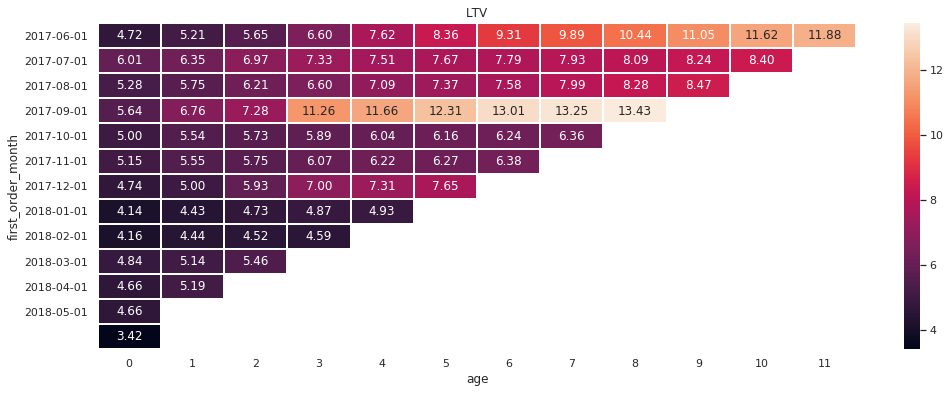

In [44]:
# <Создание тепловой карты>
sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('LTV')
ax = sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1);
ax.set_yticklabels(retention_pivot.index.date)

#### Вывод

В среднем каждый покупатель из первой когорты принес по 11,88 рублей выручки за 12 месяцев «жизни». Выделяется когорта 2017-09-01 - по ней прибыль с каждого покупателя выше, чем по остальным.	

### 2.3 Маркетинг

#### Сколько денег потратили? 

Посчитаем суммарные расходы за весь период

In [45]:
costs['costs'].sum()

329131.62

Расчитаем ежемесячные расходы и построим график.

Text(0.5, 1.0, 'Помесячная сумма затрат')

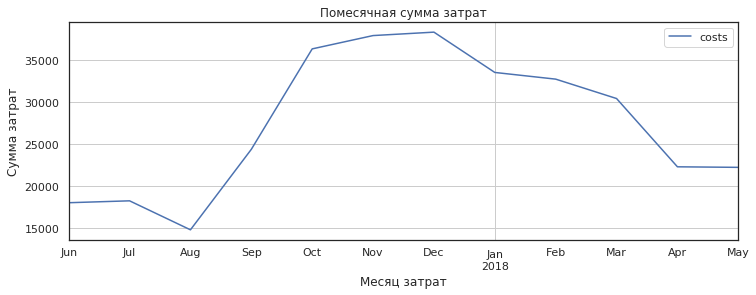

In [46]:
# <Добавим столбце с месяцем затрат>
costs['month'] = costs['dt'].astype('datetime64[M]')

# <Построим график>
costs_pivot = costs.pivot_table(index='month',values='costs',aggfunc='sum')
costs_month_plot = costs_pivot.plot(grid=True, figsize=(12, 4)) 
plt.xlabel('Месяц затрат')
plt.ylabel('Сумма затрат')
plt.title('Помесячная сумма затрат')

Посмотрим на расходы по источникам.

Text(0.5, 1.0, 'График затрат на каждый источник')

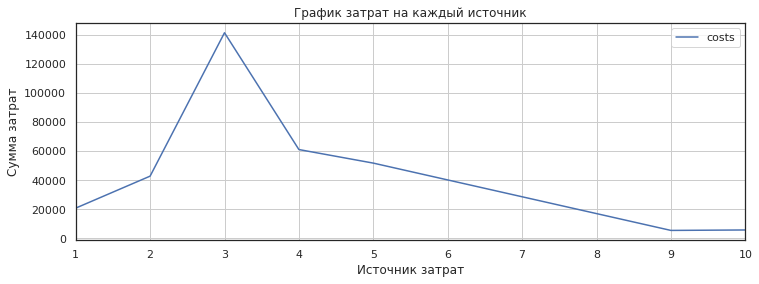

In [47]:
# <Построим график>
costs_source = costs.pivot_table(index='source_id',values='costs',aggfunc='sum')
costs_sourse_plot = costs_source.plot(grid=True, figsize=(12, 4)) 
plt.xlabel('Источник затрат')
plt.ylabel('Сумма затрат')
plt.title('График затрат на каждый источник')

#### Вывод

Всего было затрачено 329131. Наибольшее кол-во затрат произошло в период с октября по декабрь, что можно объяснить высоким сезоном. Третий источник самый затратный, самый девешый - 9 и 10.

####  Сколько стоило привлечение одного покупателя из каждого источника? (CAC)

Найдем САС путем деления расходов из одого рекламного источника на число новых покупателей, пришедших из этого рекламного источника. 
Первоначально посчитаем расходы по рекламным источникам:

In [48]:
# <Расходы по источникам>
costs_source = costs.pivot_table(index=['source_id'],values='costs',aggfunc='sum').reset_index()
costs_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Далее посчитаем кол-во новых покупателей по источникам:

In [49]:
# <Считаем кол-во новых покупателей по источникам>
first_source_per_user = visits.groupby('uid').agg({'source id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source id').agg({'uid': 'nunique'}).reset_index()
client_per_source = client_per_source.rename(columns={'source id':'source_id','uid':'buyers'})
client_per_source

,source_id,buyers
0,1,3743
1,2,4323
2,3,9138
3,4,9823
4,5,6839
5,7,1
6,9,1415
7,10,1241


Совместим вместе таблицы и расчитаем САС

In [50]:
# <Раcсчитываем САС>
report_new = pd.merge(costs_source, client_per_source, on='source_id')
report_new['cac'] = (report_new['costs'] / report_new['buyers']).round(2)
report_new

,source_id,costs,buyers,cac
0,1,20833.27,3743,5.57
1,2,42806.04,4323,9.90
2,3,141321.63,9138,15.47
3,4,61073.60,9823,6.22
4,5,51757.10,6839,7.57
5,9,5517.49,1415,3.90
6,10,5822.49,1241,4.69


In [51]:
# <Расчитываем среднее значение и разброс САС>
cac_mean = report_new['cac'].describe().round(2)
cac_mean

count     7.00
mean      7.62
std       3.99
min       3.90
25%       5.13
50%       6.22
75%       8.74
max      15.47
Name: cac, dtype: float64

#### Вывод

Среднее цена привлечения одного покупателя по источникам равняется 7,6. Минимальная цена привлечение одного покупателя из источника 9, но из него же и меньше всего кол-во привлеченных людей. Следует обратить внимания на источники 1 и 4, они наиболее оптимальные.

#### На сколько окупились расходы?

Рассчитаем ROMI: поделим LTV на CAC.

In [52]:
# <Расходы по месяцам>
costs_source = costs.pivot_table(index=['month'],values='costs',aggfunc='sum').reset_index()

# <Расчитываем САС>
cac = pd.merge(report, costs_source, left_on='first_order_month', right_on=['month'])
cac['cac'] = cac['costs'] / cac['buyers']

# <Рассчитаем ROMI>
cac['romi'] = cac['ltv'] / cac['cac']
romi = cac.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

# <Среднее по строке ROMI>
#romi.loc[:, 'ROMI'] = romi.mean(axis=1)

[Text(0, 0.5, '2017-06-01'),
 Text(0, 1.5, '2017-07-01'),
 Text(0, 2.5, '2017-08-01'),
 Text(0, 3.5, '2017-09-01'),
 Text(0, 4.5, '2017-10-01'),
 Text(0, 5.5, '2017-11-01'),
 Text(0, 6.5, '2017-12-01'),
 Text(0, 7.5, '2018-01-01'),
 Text(0, 8.5, '2018-02-01'),
 Text(0, 9.5, '2018-03-01'),
 Text(0, 10.5, '2018-04-01'),
 Text(0, 11.5, '2018-05-01')]

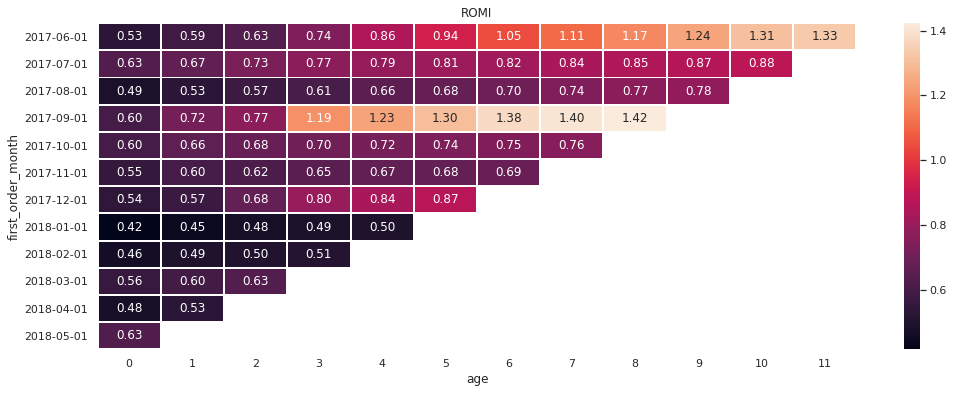

In [53]:
# <Создание тепловой карты>
sns.set(style='white')
plt.figure(figsize=(17, 6))
plt.title('ROMI')
ax = sns.heatmap(romi.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1);
ax.set_yticklabels(retention_pivot.index.date)

In [54]:
# <Усредним значения по каждой колонки и «сложим» таблицу в единую строку>
romi.iloc[:, :9].cumsum(axis=1).mean(axis=0).round(2)

age
0    0.54
1    0.58
2    0.63
3    0.72
4    0.78
5    0.86
6    0.90
7    0.97
8    1.05
dtype: float64

In [55]:
# <Примем за 6 мес. жизненный цикл и найдем среднее значение LTV>
LTV_mean = output.iloc[:7, :6]
LTV_mean.loc[:, 'LTV_sum'] = LTV_mean.sum(axis=1)
LTV_mean['LTV_sum'].mean().round(2)

7.97

In [56]:
# <Рассчитаем ROMI по источникам>
report_new['ltv_mean'] = 7.97
report_new['romi'] = (report_new['ltv_mean'] / report_new['cac']).round(2)
report_new.sort_values(by='romi', ascending=False)

,source_id,costs,buyers,cac,ltv_mean,romi
5,9,5517.49,1415,3.90,7.97,2.04
6,10,5822.49,1241,4.69,7.97,1.70
0,1,20833.27,3743,5.57,7.97,1.43
3,4,61073.60,9823,6.22,7.97,1.28
4,5,51757.10,6839,7.57,7.97,1.05
1,2,42806.04,4323,9.90,7.97,0.81
2,3,141321.63,9138,15.47,7.97,0.52


#### Вывод

По ROMI видно, что в среднем когорты окупаются к концу 8 месяца. Самыми окупаемыми источниками оказались 5, 6 и 0.

#### Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени

Построим график количества визитов по устройствам.

Text(0.5, 1.0, 'График количества визитов по устройствам')

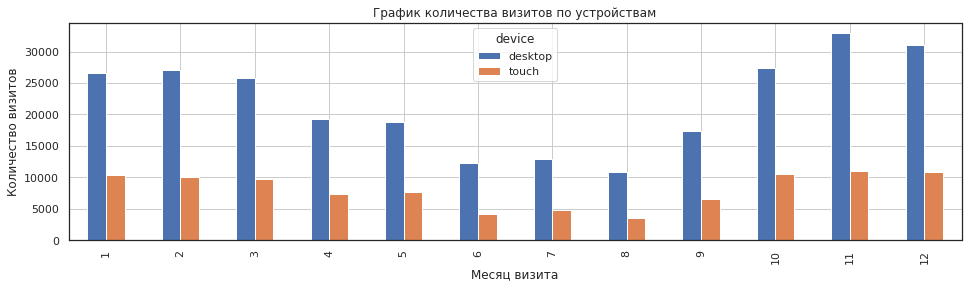

In [57]:
# <График количества визитов по устройствам>
device_plot = visits.pivot_table(index='session_month', columns='device', values='uid', aggfunc='count').plot(grid=True, kind='bar', figsize=(16, 4))
plt.xlabel('Месяц визита')
plt.ylabel('Количество визитов')
plt.title('График количества визитов по устройствам')

По графику видно, что с компьютера заходят примерно раза в 2,5 чаще, чем с мобильных устройств.

Построим графики по рекламным источникам.

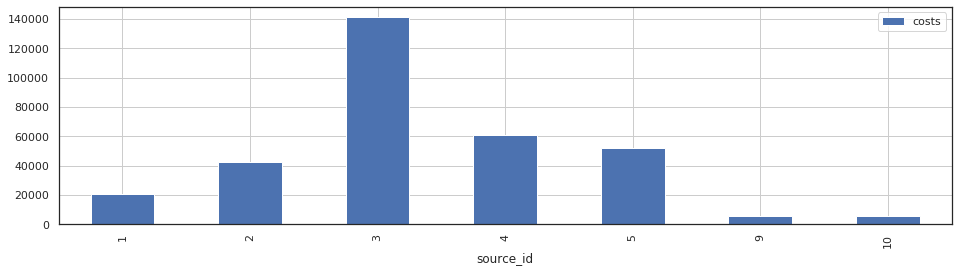

In [58]:
# <График выручки по реклманым источникам>
report_new.pivot_table(index='source_id', values='costs', aggfunc='sum').plot(grid=True, kind='bar', figsize=(16, 4))

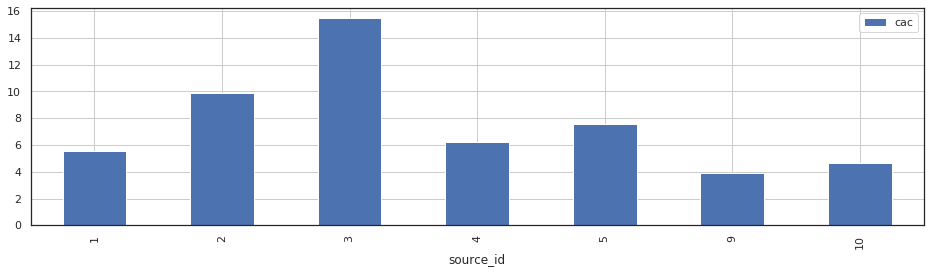

In [59]:
# <График CAC по реклманым источникам>
report_new.pivot_table(index='source_id', values='cac', aggfunc='sum').plot(grid=True, kind='bar', figsize=(16, 4))

Построим таблицу изменений метрик по времени

In [60]:
# <Таблица изменений метрик по времени>
report = report.pivot_table(index=['first_order_month'],values='revenue',aggfunc='sum')
output.loc[:, 'LTV'] = output.sum(axis=1)
ltv = output['LTV'].round(2).to_frame()
#romi.loc[:, 'ROMI'] = romi.mean(axis=1)
#romi = romi['ROMI'].round(2).to_frame()
summary = report.merge(cohort_sizes, on='first_order_month')
summary = summary.merge(ltv, on='first_order_month')
#summary = summary.merge(romi, on='first_order_month')
summary.iloc[:6, :]

,first_order_month,revenue,buyers,LTV
0,2017-06-01,24031.69,2023,11.88
1,2017-07-01,16127.92,1923,8.40
2,2017-08-01,11606.26,1370,8.47
3,2017-09-01,34676.32,2581,13.43
4,2017-10-01,27603.45,4340,6.36
5,2017-11-01,26098.99,4081,6.38


### Шаг 3. Общий вывод

По проведенному анализу можно сделать выводы:
- Retention Rate в первый месяц убывает по когортам с течением времени. Если для когорты пользователей, пришедших в июне 2017 Retention Rate в первый месяц составляет 7,9%, то для пользователей, пришедших в апреле 2018 — уже 4,8%. Так, за 11 месяцев коэффициент удержания упал на 3,1%. Это говорит, что с каждой новой когортой поведение покупателей меняется. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество работы службы поддержки;
- Среднее цена привлечения одного покупателя по источникам равняется 7,6. Минимальная цена привлечение одного покупателя из источника 9, но из него же и меньше всего кол-во привлеченных людей. Следует обратить внимания на источники 1 и 4, они наиболее оптимальные;
- В среднем каждый покупатель из первой когорты принес по 11,88 рублей выручки за 12 месяцев «жизни». Выделяется когорта 2017-09-01 - по ней прибыль с каждого покупателя выше, чем по остальным;	
- По ROMI видно, что в среднем когорты окупаются к концу 8 месяца. Самыми окупаемыми источниками оказались 5, 6 и 0.
- С компьютера заходят примерно раза в 2,5 чаще, чем с мобильных устройств. Рекомендуется больше уделять внимание этим пользователям.